In [1]:
import os

# set correct directory
os.chdir('..')


In [2]:
from src.data_ingestion.download_data import download_dataset
from src.config.config import DATA_FOLDER

c:\Users\ernes\Documents\ML Projects\spark-ecommerce\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download Data

Using the fucntion ``download_data`` to download the data from kaggle to the local machine

In [5]:
if not os.path.exists(DATA_FOLDER):
    #download_data()
    pass


After downloading the data, if  the enviroment is using HDFS to distribute the data the following bash commands will put the data into HDFS

1. Create the folder in HDFS    
``hdfs dfs -mkdir /data/olist``

2. Move the data to HDFS:
``hadoop fs -put /data/*.csv /data/olist/``

#

# Create a Spark Session to inspect the data

In [31]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd

spark = (SparkSession
            .builder
            .appName('olist')
            .getOrCreate())

spark

In [32]:
# import paths
from src.config.config import (CUSTOMER_DATASET,
                               ORDER_DATASET,
                               ORDER_ITEMS_DATASET,
                               ORDER_PAYMENTS_DATASET,
                               ORDER_REVIEWS_DATASET,
                               PRODUCTS_DATASET,
                               SELLERS_DATASET,
                               GEOLOCATION_DATASET,
                               PRODUCT_TRANSLATIONS
                               )
hdfs_path = 'data/olist/'

In [33]:
customer_dataset = spark.read.csv(hdfs_path + CUSTOMER_DATASET, header=True, inferSchema=True)
order_dataset = spark.read.csv(hdfs_path + ORDER_DATASET, header=True, inferSchema=True)
items_dataset = spark.read.csv(hdfs_path + ORDER_ITEMS_DATASET, header=True, inferSchema=True)
payments_dataset = spark.read.csv(hdfs_path + ORDER_PAYMENTS_DATASET, header=True, inferSchema=True)
reviews_dataset = spark.read.csv(hdfs_path + ORDER_REVIEWS_DATASET, header=True, inferSchema=True)
geolocation_dataset = spark.read.csv(hdfs_path + GEOLOCATION_DATASET, header=True, inferSchema=True)
products_dataset = spark.read.csv(hdfs_path + PRODUCTS_DATASET, header=True, inferSchema=True)
sellers_dataset = spark.read.csv(hdfs_path + SELLERS_DATASET, header=True, inferSchema=True)
translations = spark.read.csv(hdfs_path + PRODUCT_TRANSLATIONS, header=True, inferSchema=True)

In [136]:
items_dataset.show(1)

+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+
|            order_id|order_item_id|          product_id|           seller_id|shipping_limit_date|price|freight_value|
+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+
|00010242fe8c5a6d1...|            1|4244733e06e7ecb49...|48436dade18ac8b2b...|2017-09-19 09:45:35| 58.9|        13.29|
+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+
only showing top 1 row



In [34]:
customer_dataset.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: integer (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)



In [35]:
order_dataset.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)



In [36]:
# 
print('Num rows')
print(f'Customers: {customer_dataset.count()}')
print(f"Orders: {order_dataset.count()}")
print(f'Order Reviews: {reviews_dataset.count()}')

Num rows
Customers: 99441
Orders: 99441
Order Reviews: 104162


In [37]:
customer_dataset.describe().show()

+-------+--------------------+--------------------+------------------------+-------------------+--------------+
|summary|         customer_id|  customer_unique_id|customer_zip_code_prefix|      customer_city|customer_state|
+-------+--------------------+--------------------+------------------------+-------------------+--------------+
|  count|               99441|               99441|                   99441|              99441|         99441|
|   mean|                NULL|                NULL|       35137.47458291851|               NULL|          NULL|
| stddev|                NULL|                NULL|       29797.93899620613|               NULL|          NULL|
|    min|00012a2ce6f8dcda2...|0000366f3b9a7992b...|                    1003|abadia dos dourados|            AC|
|    max|ffffe8b65bbe3087b...|ffffd2657e2aad290...|                   99990|             zortea|            TO|
+-------+--------------------+--------------------+------------------------+-------------------+--------

### Checking Null Values

In [38]:
# check if there are null values in the data
from pyspark.sql.functions import col

print('Num Null rows')
for co in customer_dataset.columns:
    print( f'{co}:{customer_dataset.select(co).filter(col(co).isNull()).count() }')

Num Null rows
customer_id:0
customer_unique_id:0
customer_zip_code_prefix:0
customer_city:0
customer_state:0


### Checking Duplicated Values

In [39]:
customer_dataset.groupBy('customer_id').count().filter('count>1').show()

+-----------+-----+
|customer_id|count|
+-----------+-----+
+-----------+-----+



### Distribution of the customers across states

In [40]:
customer_dataset.groupBy('customer_state').count().orderBy('count', ascending=False).show()

+--------------+-----+
|customer_state|count|
+--------------+-----+
|            SP|41746|
|            RJ|12852|
|            MG|11635|
|            RS| 5466|
|            PR| 5045|
|            SC| 3637|
|            BA| 3380|
|            DF| 2140|
|            ES| 2033|
|            GO| 2020|
|            PE| 1652|
|            CE| 1336|
|            PA|  975|
|            MT|  907|
|            MA|  747|
|            MS|  715|
|            PB|  536|
|            PI|  495|
|            RN|  485|
|            AL|  413|
+--------------+-----+
only showing top 20 rows



In [41]:
# order status distributions
order_dataset.groupBy('order_status').count().orderBy('count', ascending=False).show()

+------------+-----+
|order_status|count|
+------------+-----+
|   delivered|96478|
|     shipped| 1107|
|    canceled|  625|
| unavailable|  609|
|    invoiced|  314|
|  processing|  301|
|     created|    5|
|    approved|    2|
+------------+-----+



Analysis on Payments

In [42]:
# payment methods
payments_dataset.groupBy('payment_type').count().orderBy('count', ascending=False).show()

+------------+-----+
|payment_type|count|
+------------+-----+
| credit_card|76795|
|      boleto|19784|
|     voucher| 5775|
|  debit_card| 1529|
| not_defined|    3|
+------------+-----+



In [43]:
payments_dataset.columns

['order_id',
 'payment_sequential',
 'payment_type',
 'payment_installments',
 'payment_value']

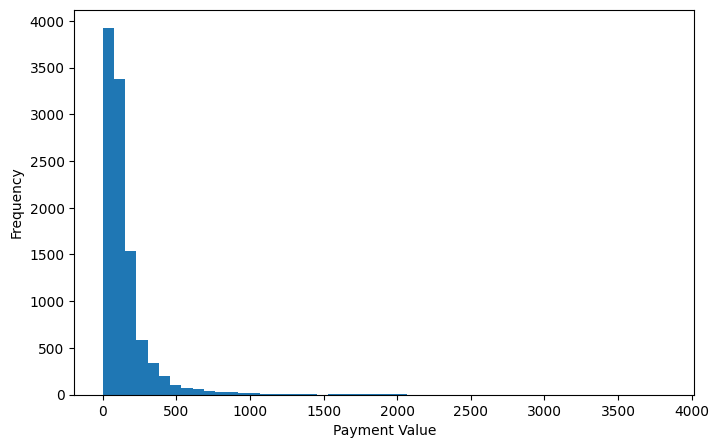

In [44]:
# payment price distribution
(
    payments_dataset
        .select('payment_value')
        .sample(fraction=0.1)
        .toPandas()
        .plot
        .hist(figsize=(8, 5), xlabel='Payment Value', legend=False, bins=50)
)

plt.show()

Product Analysis

In [120]:
order_dataset.show(3)

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+
|e481f51cbdc54678b...|9ef432eb625129730...|   delivered|     2017-10-02 10:56:33|2017-10-02 11:07:15|         2017-10-04 19:55:00|          2017-10-10 21:25:13|          2017-10-18 00:00:00|
|53cdb2fc8bc7dce0b...|b0830fb4747a6c6d2...|   delivered|     2018-07-24 20:41:37|2018-07-26 03:24:27|         2018-07-26 14:31:00|          2018-08-07 15:27:45|          2018-08-13 00:00:00|
|47770eb9100c2d0c4...|41ce2a54c0b03bf34...|  

In [129]:
order_product = (order_dataset
    .join(items_dataset, order_dataset.order_id == items_dataset.order_id, 'inner')
    )

order_product = (
    order_product
        .join(products_dataset, order_product.product_id == products_dataset.product_id, 'inner')
)

product_details = order_product.select(['customer_id', 'price', 'freight_value', 'product_category_name']).cache()

In [131]:

product_details.show()

+--------------------+------+-------------+---------------------+
|         customer_id| price|freight_value|product_category_name|
+--------------------+------+-------------+---------------------+
|3ce436f183e68e078...|  58.9|        13.29|           cool_stuff|
|f6dd3ec061db4e398...| 239.9|        19.93|             pet_shop|
|6489ae5e4333f3693...| 199.0|        17.87|     moveis_decoracao|
|d4eb9395c8c0431ee...| 12.99|        12.79|           perfumaria|
|58dbd0b2d70206bf4...| 199.9|        18.14|   ferramentas_jardim|
|816cbea969fe5b689...|  21.9|        12.69| utilidades_domest...|
|32e2e6ab09e778d99...|  19.9|        11.85|            telefonia|
|9ed5e522dd9dd85b4...| 810.0|        70.75|   ferramentas_jardim|
|16150771dfd477626...|145.95|        11.65|         beleza_saude|
|351d3cb2cee3c7fd0...| 53.99|         11.4|      livros_tecnicos|
|c6fc061d86fab1e2b...| 59.99|         8.88|         beleza_saude|
|6a899e55865de6549...|  45.0|        12.98| fashion_bolsas_e_...|
|5d178120c

In [132]:
items_dataset.show(5)

+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+
|            order_id|order_item_id|          product_id|           seller_id|shipping_limit_date|price|freight_value|
+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+
|00010242fe8c5a6d1...|            1|4244733e06e7ecb49...|48436dade18ac8b2b...|2017-09-19 09:45:35| 58.9|        13.29|
|00018f77f2f0320c5...|            1|e5f2d52b802189ee6...|dd7ddc04e1b6c2c61...|2017-05-03 11:05:13|239.9|        19.93|
|000229ec398224ef6...|            1|c777355d18b72b67a...|5b51032eddd242adc...|2018-01-18 14:48:30|199.0|        17.87|
|00024acbcdf0a6daa...|            1|7634da152a4610f15...|9d7a1d34a50524090...|2018-08-15 10:10:18|12.99|        12.79|
|00042b26cf59d7ce6...|            1|ac6c3623068f30de0...|df560393f3a51e745...|2017-02-13 13:57:51|199.9|        18.14|
+--------------------+-------------+------------

In [133]:
# top selled categories by quantity
from pyspark.sql.functions import count

top_product = (
    product_details
        .select(['product_category_name'])
        .groupBy('product_category_name')
        .agg(count('product_category_name').alias('total_sales'))
        .orderBy('total_sales', ascending=False)
    
)
top_product.show()

+---------------------+-----------+
|product_category_name|total_sales|
+---------------------+-----------+
|      cama_mesa_banho|      11115|
|         beleza_saude|       9670|
|        esporte_lazer|       8641|
|     moveis_decoracao|       8334|
| informatica_acess...|       7827|
| utilidades_domest...|       6964|
|   relogios_presentes|       5991|
|            telefonia|       4545|
|   ferramentas_jardim|       4347|
|           automotivo|       4235|
|           brinquedos|       4117|
|           cool_stuff|       3796|
|           perfumaria|       3419|
|                bebes|       3065|
|          eletronicos|       2767|
|            papelaria|       2517|
| fashion_bolsas_e_...|       2031|
|             pet_shop|       1947|
|    moveis_escritorio|       1691|
|       consoles_games|       1137|
+---------------------+-----------+
only showing top 20 rows



In [134]:
# most revenue categories
top_product =(
        product_details
            .select(['product_category_name', 'price'])
            .groupBy('product_category_name')
            .agg(sum('price').alias('total_sales'))
            .orderBy('total_sales', ascending=False)
            )
top_product.show(10)

+---------------------+------------------+
|product_category_name|       total_sales|
+---------------------+------------------+
|         beleza_saude|1258681.3399999938|
|   relogios_presentes| 1205005.679999998|
|      cama_mesa_banho|1036988.6799999807|
|        esporte_lazer| 988048.9699999837|
| informatica_acess...|  911954.319999988|
|     moveis_decoracao| 729762.4899999866|
|           cool_stuff| 635290.8499999974|
| utilidades_domest...| 632248.6599999928|
|           automotivo|  592720.109999997|
|   ferramentas_jardim|485256.45999999647|
+---------------------+------------------+
only showing top 10 rows



Delivery Time Analysis

In [138]:
from pyspark.sql.functions import datediff, to_date

In [143]:
order_dataset.show(3)

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+
|e481f51cbdc54678b...|9ef432eb625129730...|   delivered|     2017-10-02 10:56:33|2017-10-02 11:07:15|         2017-10-04 19:55:00|          2017-10-10 21:25:13|          2017-10-18 00:00:00|
|53cdb2fc8bc7dce0b...|b0830fb4747a6c6d2...|   delivered|     2018-07-24 20:41:37|2018-07-26 03:24:27|         2018-07-26 14:31:00|          2018-08-07 15:27:45|          2018-08-13 00:00:00|
|47770eb9100c2d0c4...|41ce2a54c0b03bf34...|  

In [164]:
orders_datetime = (order_dataset
        .filter(col('order_status') == 'delivered')
        .select(['order_id', 'order_purchase_timestamp', 'order_delivered_customer_date'])
        )

orders_datetime = orders_datetime.withColumn('day_to_deliver', datediff(to_date(col('order_delivered_customer_date')),
                                       to_date(col('order_purchase_timestamp'))
                                       )
                )
orders_datetime.show()

+--------------------+------------------------+-----------------------------+--------------+
|            order_id|order_purchase_timestamp|order_delivered_customer_date|day_to_deliver|
+--------------------+------------------------+-----------------------------+--------------+
|e481f51cbdc54678b...|     2017-10-02 10:56:33|          2017-10-10 21:25:13|             8|
|53cdb2fc8bc7dce0b...|     2018-07-24 20:41:37|          2018-08-07 15:27:45|            14|
|47770eb9100c2d0c4...|     2018-08-08 08:38:49|          2018-08-17 18:06:29|             9|
|949d5b44dbf5de918...|     2017-11-18 19:28:06|          2017-12-02 00:28:42|            14|
|ad21c59c0840e6cb8...|     2018-02-13 21:18:39|          2018-02-16 18:17:02|             3|
|a4591c265e18cb1dc...|     2017-07-09 21:57:05|          2017-07-26 10:57:55|            17|
|6514b8ad8028c9f2c...|     2017-05-16 13:10:30|          2017-05-26 12:55:51|            10|
|76c6e866289321a7c...|     2017-01-23 18:29:09|          2017-02-02 14

+---------------------+
|Average Delivery Time|
+---------------------+
|   12.496848761272934|
+---------------------+

+-----------------+
|Std Delivery Time|
+-----------------+
|9.555071259126024|
+-----------------+

+-----------------+
|Min Delivery Time|
+-----------------+
|                0|
+-----------------+

+-----------------+
|Max Delivery Time|
+-----------------+
|              210|
+-----------------+

Q1 7.0
Q2 10.0
Q3 15.0

top 10 longest delivers
+--------------+
|day_to_deliver|
+--------------+
|           210|
|           208|
|           196|
|           195|
|           195|
|           194|
|           191|
|           190|
|           188|
|           188|
+--------------+
only showing top 10 rows



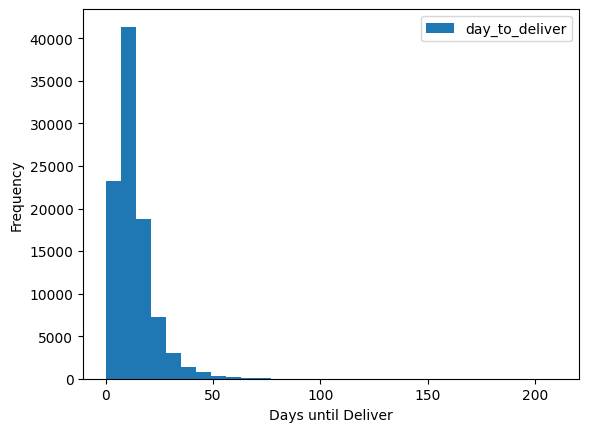

In [225]:
from pyspark.sql.functions import mean, std, min, max

#mean
orders_datetime.agg(mean(col('day_to_deliver')).alias('Average Delivery Time')).show()

# standar deviation
orders_datetime.agg(std(col('day_to_deliver')).alias('Std Delivery Time')).show()

#min
orders_datetime.agg(min(col('day_to_deliver')).alias('Min Delivery Time')).show()

#max
orders_datetime.agg(max(col('day_to_deliver')).alias('Max Delivery Time')).show()

# std
q1,q2,q3,= orders_datetime.approxQuantile('day_to_deliver', probabilities=[0.25, 0.5, 0.75], relativeError=0.01)


# quantiles
print('Q1', q1)
print('Q2', q2)
print('Q3', q3)



# top 10 longest delivers
print('\ntop 10 longest delivers')
orders_datetime.select('day_to_deliver').orderBy('day_to_deliver', ascending=False).show(10)

# plot histogram
orders_datetime.select(['day_to_deliver']).toPandas().plot(kind='hist', bins=30, xlabel='Days until Deliver');


In [ ]:
# beyond 30 days
orders_datetime.filter('day_to_deliver > 30').count()

4294